# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/nettverksanalyse.ipynb

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sgis as sg

## Hente data

Henter bygningspunkter i Oslo.

In [2]:
aar = 2022
kommnr = "0301"

bygningspunktsti = f"ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data/{aar}/SMAT_bygg_punkt_p{aar}_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[("KOMMUNENR", "=", kommnr)],
    columns=["KOMMUNENR", "geometry"]
)

Lager noen start- og sluttpunkter.

In [3]:
origins = bygg.sample(1000)
origins.index = np.arange(0, 1000)
origins

KOMMUNENR                        geometry
0        0301  POINT (264322.000 6644803.000)
1        0301  POINT (261048.000 6650480.000)
2        0301  POINT (261249.000 6654090.000)
3        0301  POINT (268491.000 6649346.000)
4        0301  POINT (266318.000 6642562.000)
..        ...                             ...
995      0301  POINT (261764.000 6653608.000)
996      0301  POINT (268165.000 6649474.000)
997      0301  POINT (257984.000 6653901.000)
998      0301  POINT (265964.000 6652012.000)
999      0301  POINT (265633.000 6649577.000)

[1000 rows x 2 columns]

In [4]:
destinations = bygg.sample(1000)
destinations.index = np.arange(1000, 2000)
destinations

KOMMUNENR                        geometry
1000      0301  POINT (261118.000 6654087.000)
1001      0301  POINT (263516.000 6650025.000)
1002      0301  POINT (264595.000 6643095.000)
1003      0301  POINT (263789.000 6648721.000)
1004      0301  POINT (263710.000 6647745.000)
...        ...                             ...
1995      0301  POINT (258500.000 6651380.000)
1996      0301  POINT (269789.000 6650813.000)
1997      0301  POINT (269230.000 6654400.000)
1998      0301  POINT (259520.000 6653563.000)
1999      0301  POINT (257432.000 6655667.000)

[1000 rows x 2 columns]

Henter vegdata i Oslo for 2022 med relevante kolonner: fart og retning.

In [5]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger_oslo = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[("KOMMUNENR", "=", kommnr)],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "KOMMUNENR", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger_oslo

oneway  drivetime_fw  drivetime_bw KOMMUNENR  \
0          B      0.216611      0.216611      0301   
1          B      0.064631      0.064631      0301   
2          B      0.023387      0.023387      0301   
3          B      0.174470      0.174470      0301   
4          B      0.085934      0.085934      0301   
...      ...           ...           ...       ...   
93390     TF     -1.000000      0.003683      0301   
93391     TF     -1.000000      0.031986      0301   
93392     TF     -1.000000      0.010607      0301   
93393     TF     -1.000000      0.004257      0301   
93394     TF     -1.000000      0.128560      0301   

                                                geometry  
0      MULTILINESTRING Z ((258028.440 6674249.890 413...  
1      MULTILINESTRING Z ((263329.703 6652880.398 88....  
2      MULTILINESTRING Z ((270274.700 6651212.900 154...  
3      MULTILINESTRING Z ((267240.000 6644124.500 133...  
4      MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                  ...  
93390  MULTILINESTRING Z ((263871.009 6648498.376 29....  
93391  MULTILINESTRING Z ((267727.200 6649124.300 155...  
93392  MULTILINESTRING Z ((263871.400 6648500.800 29....  
93393  MULTILINESTRING Z ((256561.560 6651007.630 63....  
93394  MULTILINESTRING Z ((262522.672 6651527.844 52....  

[93395 rows x 5 columns]

## Gjør klar til nettverksanalyse

Før vegene kan brukes i nettverksanalyse med retning, må det gjøres noen tilpasninger.

1) Man må duplisere og snu vegene som går begge retninger (oneway=="B").

2) Snu vegene som går i motsatt retning (oneway=="TF").

In [6]:
antall_per_retning = veger_oslo.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

oneway                 hva_må_gjøres
B    82230  Duplisere og snu duplikatene
FT    7353                     Ingenting
TF    3812                           Snu

3) Man må også lage en minutt-kolonne av kjøretid-kolonnene.

In [7]:
veger_oslo[["oneway", "drivetime_fw", "drivetime_bw"]]

oneway  drivetime_fw  drivetime_bw
0          B      0.216611      0.216611
1          B      0.064631      0.064631
2          B      0.023387      0.023387
3          B      0.174470      0.174470
4          B      0.085934      0.085934
...      ...           ...           ...
93390     TF     -1.000000      0.003683
93391     TF     -1.000000      0.031986
93392     TF     -1.000000      0.010607
93393     TF     -1.000000      0.004257
93394     TF     -1.000000      0.128560

[93395 rows x 3 columns]

Dette kan gjøres sånn her:

In [8]:
veger_med_retning = sg.make_directed_network_norway(veger_oslo)
veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((263329.703 6652880.398 88....  
2       MULTILINESTRING Z ((270274.700 6651212.900 154...  
3       MULTILINESTRING Z ((267240.000 6644124.500 133...  
4       MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                   ...  
175620  MULTILINESTRING Z ((263871.400 6648500.800 29....  
175621  MULTILINESTRING Z ((267749.000 6649137.700 156...  
175622  MULTILINESTRING Z ((263874.800 6648507.000 29....  
175623  MULTILINESTRING Z ((256560.200 6651010.200 63....  
175624  MULTILINESTRING Z ((262543.865 6651593.052 54....  

[175541 rows x 4 columns]

Eller en mer generell variant:

In [9]:
veger_med_retning = sg.make_directed_network(
    veger_oslo,
    direction_col="oneway",
    direction_vals_bft=("B", "FT", "TF"),
    minute_cols=("drivetime_fw", "drivetime_bw"),
)

veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((263329.703 6652880.398 88....  
2       MULTILINESTRING Z ((270274.700 6651212.900 154...  
3       MULTILINESTRING Z ((267240.000 6644124.500 133...  
4       MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                   ...  
175620  MULTILINESTRING Z ((263871.400 6648500.800 29....  
175621  MULTILINESTRING Z ((267749.000 6649137.700 156...  
175622  MULTILINESTRING Z ((263874.800 6648507.000 29....  
175623  MULTILINESTRING Z ((256560.200 6651010.200 63....  
175624  MULTILINESTRING Z ((262543.865 6651593.052 54....  

[175541 rows x 4 columns]

In [10]:
print("Kilometer før:", veger_oslo.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 3851.4819685472407
Kilometer nå: 7248.592623912765


In [11]:
veger_med_retning.minutes

0         0.216611
1         0.064631
2         0.023387
3         0.174470
4         0.085934
            ...   
175620    0.003683
175621    0.031986
175622    0.010607
175623    0.004257
175624    0.128560
Name: minutes, Length: 175541, dtype: float64

4) Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne nettverksøyene:

In [12]:
veger_med_retning = sg.get_connected_components(veger_med_retning)
veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  connected  
0       LINESTRING Z (258028.440 6674249.890 413.751, ...        0.0  
1       LINESTRING Z (263329.703 6652880.398 88.022, 2...        1.0  
2       LINESTRING Z (270274.700 6651212.900 154.767, ...        0.0  
3       LINESTRING Z (267240.000 6644124.500 133.461, ...        1.0  
4       LINESTRING Z (273365.300 6652133.100 174.571, ...        1.0  
...                                                   ...        ...  
175620  LINESTRING Z (263871.400 6648500.800 29.259, 2...        1.0  
175621  LINESTRING Z (267749.000 6649137.700 156.064, ...        1.0  
175622  LINESTRING Z (263874.800 6648507.000 29.759, 2...        1.0  
175623  LINESTRING Z (256560.200 6651010.200 63.654, 2...        1.0  
175624  LINESTRING Z (262543.865 6651593.052 54.090, 2...        1.0  

[175541 rows x 5 columns]

In [13]:
sg.samplemap(veger_med_retning, "connected")

Fjerne nettverksøyene:

In [14]:
veger_ned_tilknytning = veger_med_retning[veger_med_retning.connected == 1]
veger_ned_tilknytning

oneway   minutes KOMMUNENR  \
1           B  0.064631      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
5           B  0.119831      0301   
6           B  0.050873      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  connected  
1       LINESTRING Z (263329.703 6652880.398 88.022, 2...        1.0  
3       LINESTRING Z (267240.000 6644124.500 133.461, ...        1.0  
4       LINESTRING Z (273365.300 6652133.100 174.571, ...        1.0  
5       LINESTRING Z (273398.500 6651934.000 163.171, ...        1.0  
6       LINESTRING Z (263319.400 6652894.300 87.962, 2...        1.0  
...                                                   ...        ...  
175620  LINESTRING Z (263871.400 6648500.800 29.259, 2...        1.0  
175621  LINESTRING Z (267749.000 6649137.700 156.064, ...        1.0  
175622  LINESTRING Z (263874.800 6648507.000 29.759, 2...        1.0  
175623  LINESTRING Z (256560.200 6651010.200 63.654, 2...        1.0  
175624  LINESTRING Z (262543.865 6651593.052 54.090, 2...        1.0  

[160137 rows x 5 columns]

In [15]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 7248.592623912765
Kilometer nå: 6364.053626251761


Nå er vegene klare. 

Så trenger vi noen regler for hvordan analysen skal gjennomføres.

In [16]:
rules = sg.NetworkAnalysisRules(
    directed=True,
    weight="minutes",
    search_tolerance=500, # meter
)
rules

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=False, nodedist_multiplier=None, nodedist_kmh=None)

Så kan vegene og reglene puttes inni NetworkAnalysis-klassen.

In [17]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=rules)
nwa

NetworkAnalysis(
    network=Network(6364 km, percent_bidirectional=87),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=False, ...),
    log=True, detailed_log=False,
)

Nå er vi klare!

### Først en liten test av retning
La oss teste at retningen lages riktig.

Tur-retur Vippetangen-Ryen skal gå i ulike ulike tunnelløp.

In [18]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger_oslo.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger_oslo.crs)

In [19]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

## Finn rutefrekvens

In [20]:
fra = origins.sample(75)
til = destinations.sample(75)

In [21]:
frequencies = nwa.get_route_frequencies(fra, til)

frequencies.nlargest(3, "frequency")

oneway   minutes KOMMUNENR  connected  idx_orig  \
158844     TF  0.015047      0301        1.0    174327   
158846     TF  0.001014      0301        1.0    174329   
158773     TF  0.013206      0301        1.0    174256   

                                          source_wkt  \
158844  POINT (263700.8590000002 6653774.3379999995)   
158846         POINT (263699.9060000004 6653774.592)   
158773                    POINT (263687.5 6653777.9)   

                                          target_wkt source target  n_source  \
158844           POINT (263714.7000000002 6653769.6)  78447  72978         2   
158846  POINT (263700.8590000002 6653774.3379999995)  78448  78447         2   
158773         POINT (263699.9060000004 6653774.592)  78409  78448         2   

        n_target     meters  frequency  \
158844         3  14.629488      824.0   
158846         2   0.986268      824.0   
158773         2  12.839459      824.0   

                                                 geometry  
158844  LINESTRING Z (263700.859 6653774.338 121.949, ...  
158846  LINESTRING Z (263699.906 6653774.592 121.914, ...  
158773  LINESTRING Z (263687.500 6653777.900 121.463, ...

Kartlegg resultatene.

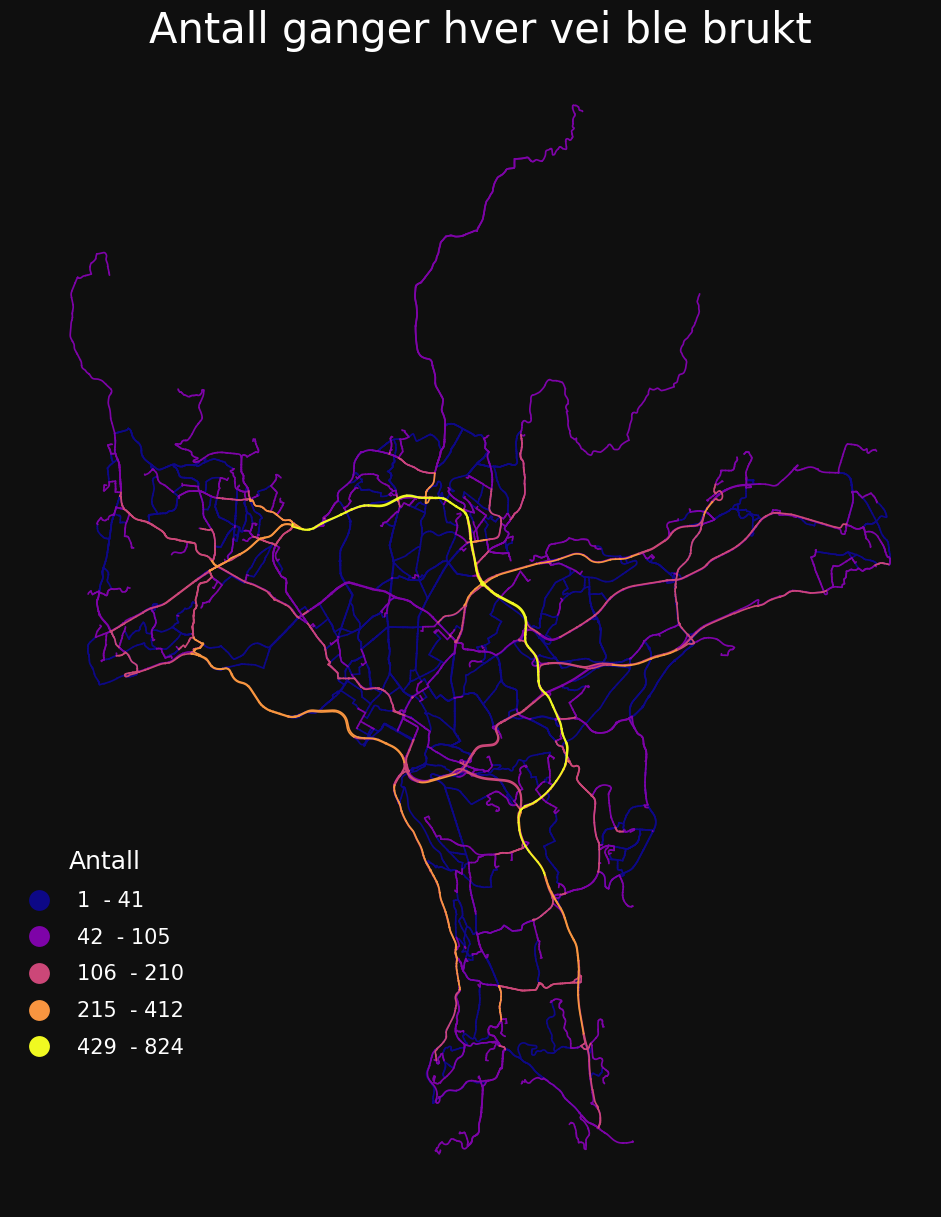

In [22]:
m = sg.ThematicMap(sg.buff(frequencies, 18), column="frequency", size=15)
m.black = True
m.cmap = "plasma" # fargepaletten
m.title = "Antall ganger hver vei ble brukt"
m.legend.title = "Antall"
m.plot()

## Finn raskeste rute
Velger ett startpunkt for illustrasjons skyld.

In [23]:
origin = bygg.loc[[2_470_929]]

In [24]:
routes = nwa.get_route(
    origins=origin,
    destinations=destinations.sample(15),
)

routes

origin  destination    minutes  \
0   2470929         1341  16.711989   
1   2470929         1060  15.351773   
2   2470929         1826   5.900169   
3   2470929         1174  15.357186   
4   2470929         1500   8.471206   
5   2470929         1853  17.869446   
6   2470929         1654  15.666126   
7   2470929         1272   6.306988   
8   2470929         1631  22.153776   
9   2470929         1264  10.870622   
10  2470929         1796   5.284677   
11  2470929         1850   7.446060   
12  2470929         1862  13.334926   
13  2470929         1927  16.602365   
14  2470929         1985   6.111771   

                                             geometry  
0   MULTILINESTRING Z ((262841.200 6651029.403 30....  
1   MULTILINESTRING Z ((258837.000 6652306.700 67....  
2   MULTILINESTRING Z ((263167.883 6652110.251 69....  
3   MULTILINESTRING Z ((272369.405 6652245.404 160...  
4   MULTILINESTRING Z ((260044.700 6651838.600 60....  
5   MULTILINESTRING Z ((273217.204 6652945.302 181...  
6   MULTILINESTRING Z ((272582.500 6653859.000 187...  
7   MULTILINESTRING Z ((262841.200 6651029.403 30....  
8   MULTILINESTRING Z ((259058.039 6654755.717 204...  
9   MULTILINESTRING Z ((269605.200 6650854.300 162...  
10  MULTILINESTRING Z ((262841.200 6651029.403 30....  
11  MULTILINESTRING Z ((264187.235 6649780.053 64....  
12  MULTILINESTRING Z ((260075.610 6653673.936 145...  
13  MULTILINESTRING Z ((272592.800 6651328.900 162...  
14  MULTILINESTRING Z ((262841.200 6651029.403 30....

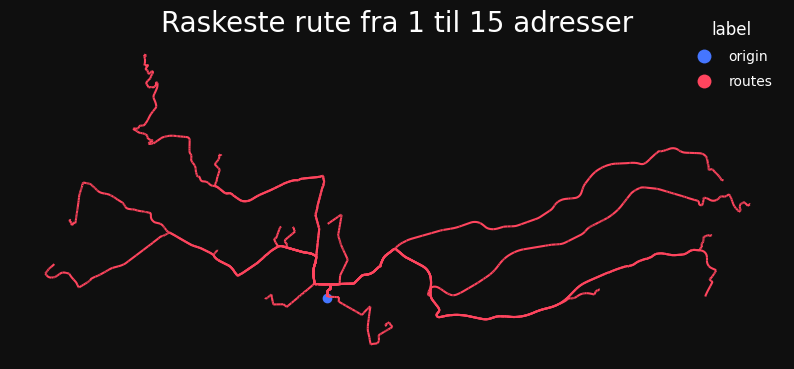

In [25]:
m = sg.ThematicMap(routes, origin, size=10)
m.black = True
m.title = "Raskeste rute fra 1 til 15 adresser"
m.plot()

### Service area

In [26]:
service_areas = nwa.service_area(
    origin,
    breaks=np.arange(1, 11),
)

service_areas

origin  minutes                                           geometry
0  2470929        1  MULTILINESTRING Z ((263020.500 6650780.000 27....
1  2470929        2  MULTILINESTRING Z ((262888.000 6651171.900 27....
2  2470929        3  MULTILINESTRING Z ((262288.231 6650825.310 40....
3  2470929        4  MULTILINESTRING Z ((262181.300 6650911.300 60....
4  2470929        5  MULTILINESTRING Z ((263821.406 6652568.059 95....
5  2470929        6  MULTILINESTRING Z ((263329.703 6652880.398 88....
6  2470929        7  MULTILINESTRING Z ((263319.400 6652894.300 87....
7  2470929        8  MULTILINESTRING Z ((266330.200 6652884.300 186...
8  2470929        9  MULTILINESTRING Z ((266598.500 6653450.000 192...
9  2470929       10  MULTILINESTRING Z ((266757.440 6653684.640 217...

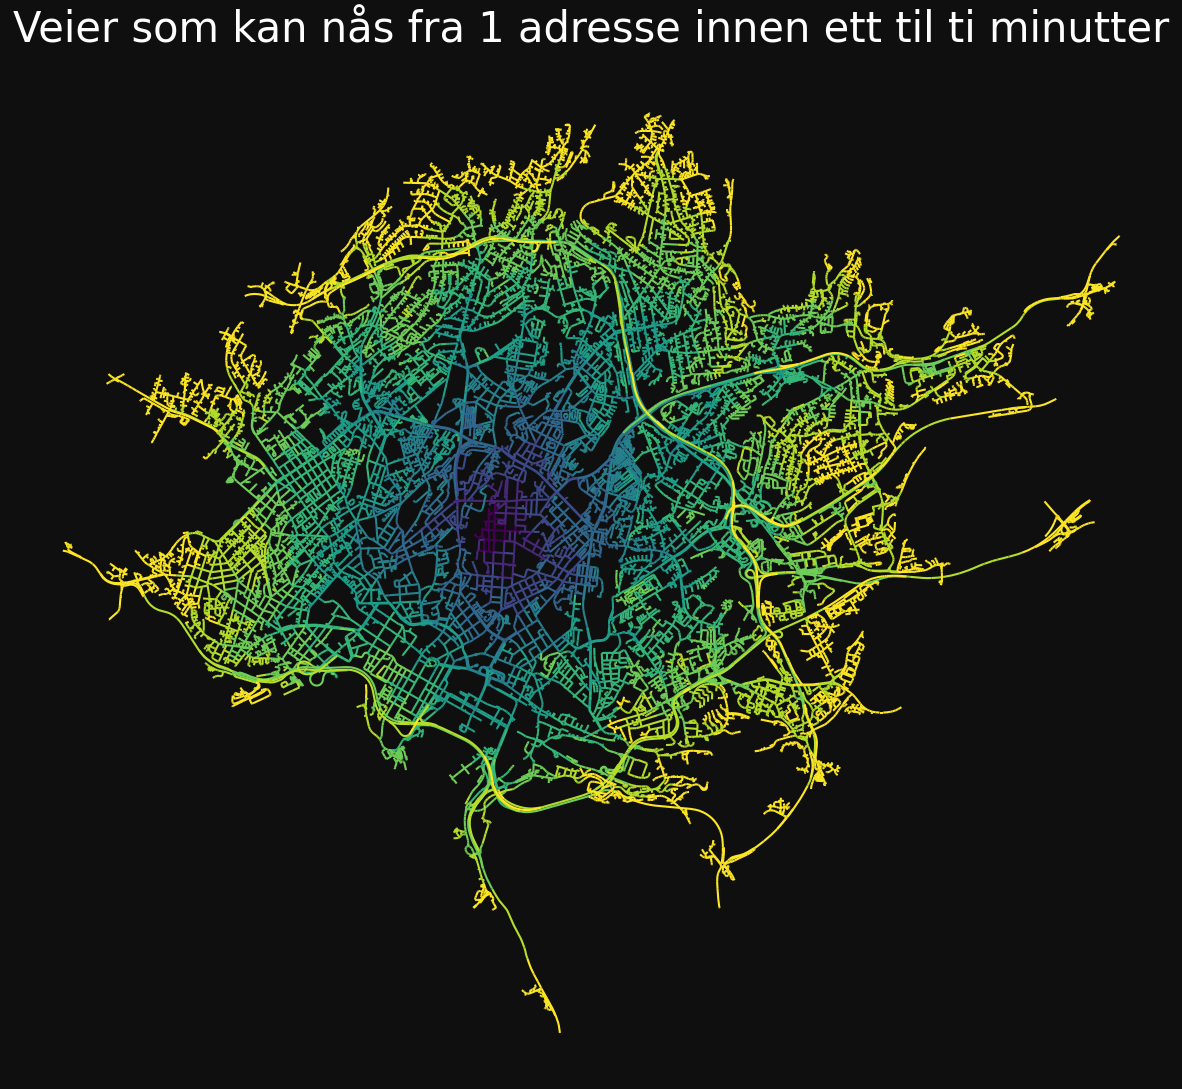

In [27]:
m = sg.ThematicMap(service_areas, column="minutes", size=15)
m.black = True
m.k = 10
m.title = "Veier som kan nås fra 1 adresse innen ett til ti minutter"
m.legend = False
m.plot()

Sjekk loggen:

In [28]:
nwa.log

endtime  minutes_elapsed                 method  origins_count  \
0 2023-04-19 10:46:19              0.1              get_route              1   
1 2023-04-19 10:46:24              0.1              get_route              1   
2 2023-04-19 10:46:38              0.2  get_route_frequencies             75   
3 2023-04-19 10:46:48              0.1              get_route              1   
4 2023-04-19 10:46:52              0.1           service_area              1   

   destinations_count  percent_missing  cost_mean  percent_bidirectional  
0                 1.0              0.0   6.354152                     87  
1                 1.0              0.0   5.357292                     87  
2                75.0              0.0   0.075467                     87  
3                15.0              0.0  12.229272                     87  
4                 NaN              0.0   5.500000                     87

### Reisetider: OD Cost Matrix

In [29]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)
od

origin  destination    minutes
0            0         1000  20.258651
1            0         1001  11.701136
2            0         1002   5.405046
3            0         1003  10.127977
4            0         1004   6.407684
...        ...          ...        ...
999995     999         1995  12.806359
999996     999         1996   7.196484
999997     999         1997  13.513081
999998     999         1998  14.001987
999999     999         1999  20.512629

[1000000 rows x 3 columns]

Sjekk hvor mange prosent som mangler:

In [30]:
od.minutes.isna().mean() * 100

1.7919999999999998

Kolonnene 'origin' og 'destination' bruker index-en til inputene.

Man kan derfor enkelt koble resultatene med start- og sluttpunktene:

In [31]:
origins_joinet = origins.join(od.set_index("origin"))
origins_joinet

KOMMUNENR                        geometry  destination    minutes
0        0301  POINT (264322.000 6644803.000)         1000  20.258651
0        0301  POINT (264322.000 6644803.000)         1001  11.701136
0        0301  POINT (264322.000 6644803.000)         1002   5.405046
0        0301  POINT (264322.000 6644803.000)         1003  10.127977
0        0301  POINT (264322.000 6644803.000)         1004   6.407684
..        ...                             ...          ...        ...
999      0301  POINT (265633.000 6649577.000)         1995  12.806359
999      0301  POINT (265633.000 6649577.000)         1996   7.196484
999      0301  POINT (265633.000 6649577.000)         1997  13.513081
999      0301  POINT (265633.000 6649577.000)         1998  14.001987
999      0301  POINT (265633.000 6649577.000)         1999  20.512629

[1000000 rows x 4 columns]

In [32]:
destinations_joinet = destinations.join(od.set_index("destination"))
destinations_joinet

KOMMUNENR                        geometry  origin    minutes
1000      0301  POINT (261118.000 6654087.000)       0  20.258651
1000      0301  POINT (261118.000 6654087.000)       1  10.143608
1000      0301  POINT (261118.000 6654087.000)       2   1.269486
1000      0301  POINT (261118.000 6654087.000)       3  17.810741
1000      0301  POINT (261118.000 6654087.000)       4  21.066889
...        ...                             ...     ...        ...
1999      0301  POINT (257432.000 6655667.000)     995  11.145367
1999      0301  POINT (257432.000 6655667.000)     996  22.204018
1999      0301  POINT (257432.000 6655667.000)     997   7.752541
1999      0301  POINT (257432.000 6655667.000)     998  18.597293
1999      0301  POINT (257432.000 6655667.000)     999  20.512629

[1000000 rows x 4 columns]

Eller koble på aggregert data:

In [33]:
origins["minutes_mean"] = od.groupby("origin").minutes.mean()
origins["n_missing"] = len(origins) - od.groupby("origin", dropna=False).minutes.count()
origins

KOMMUNENR                        geometry  minutes_mean  n_missing
0        0301  POINT (264322.000 6644803.000)     15.303490          8
1        0301  POINT (261048.000 6650480.000)     12.669926          8
2        0301  POINT (261249.000 6654090.000)     15.846195          8
3        0301  POINT (268491.000 6649346.000)     15.929818          8
4        0301  POINT (266318.000 6642562.000)     16.642381          8
..        ...                             ...           ...        ...
995      0301  POINT (261764.000 6653608.000)     13.327319          8
996      0301  POINT (268165.000 6649474.000)     13.708680          8
997      0301  POINT (257984.000 6653901.000)     16.190927          8
998      0301  POINT (265964.000 6652012.000)     12.884688          8
999      0301  POINT (265633.000 6649577.000)     12.286678          8

[1000 rows x 4 columns]

La oss undersøke hvilke punkter som har mye manglende data. 

In [34]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

In [35]:
sg.explore(origins, column="minutes_mean", scheme="quantiles")

Hvis man vil bruke en kolonne som id-er heller enn index-en, kan man sette index-en inni funksjonen:

In [36]:
od = nwa.od_cost_matrix(
    origins.set_index("KOMMUNENR"),
    destinations,
)

od

origin  destination    minutes
0        0301         1000  20.258651
1        0301         1001  11.701136
2        0301         1002   5.405046
3        0301         1003  10.127977
4        0301         1004   6.407684
...       ...          ...        ...
999995   0301         1995  12.806359
999996   0301         1996   7.196484
999997   0301         1997  13.513081
999998   0301         1998  14.001987
999999   0301         1999  20.512629

[1000000 rows x 3 columns]

Så kan man oppsummere for kommunene direkte:

In [37]:
oppsummert_kommunevis = od.groupby("origin").agg(
    minutes_mean=("minutes", "mean"),
    count=("minutes", "count"),
)

oppsummert_kommunevis.index.name = "KOMMUNENR"
oppsummert_kommunevis.reset_index()

KOMMUNENR  minutes_mean   count
0      0301     15.764486  982080

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

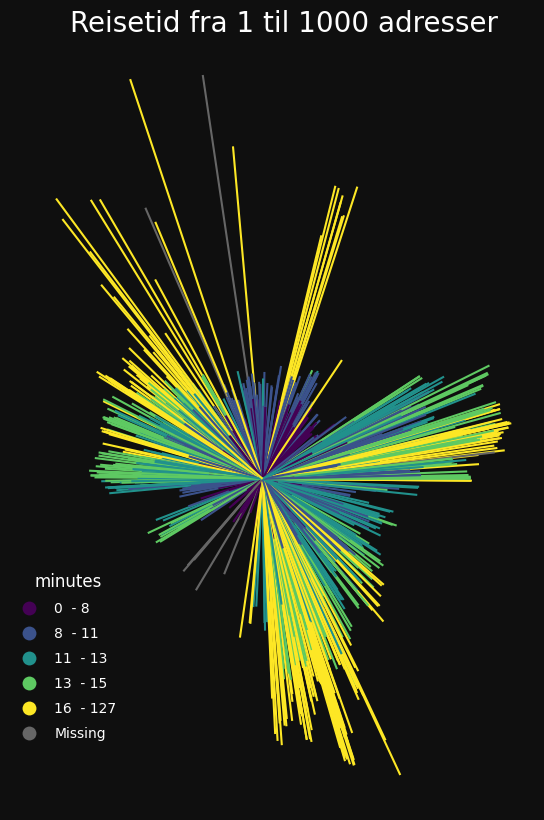

In [38]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=10)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

## Finn raskeste k ruter
k = antall

origin  destination    minutes   k  \
0  2470929      2538349   8.977744   1   
1  2470929      2538349   9.019577   2   
2  2470929      2538349  10.702815   3   
3  2470929      2538349  11.393830   4   
4  2470929      2538349  11.659811   5   
5  2470929      2538349  12.295612   6   
6  2470929      2538349  12.971575   7   
7  2470929      2538349  13.700938   8   
8  2470929      2538349  13.920801   9   
9  2470929      2538349  14.068021  10   

                                            geometry  
0  MULTILINESTRING Z ((268028.442 6652506.931 153...  
1  MULTILINESTRING Z ((268028.442 6652506.931 153...  
2  MULTILINESTRING Z ((268028.442 6652506.931 153...  
3  MULTILINESTRING Z ((268028.442 6652506.931 153...  
4  MULTILINESTRING Z ((268028.442 6652506.931 153...  
5  MULTILINESTRING Z ((268242.300 6652393.600 135...  
6  MULTILINESTRING Z ((268242.300 6652393.600 135...  
7  MULTILINESTRING Z ((268028.442 6652506.931 153...  
8  MULTILINESTRING Z ((268242.300 6652393.600 135...  
9  MULTILINESTRING Z ((268242.300 6652393.600 135...

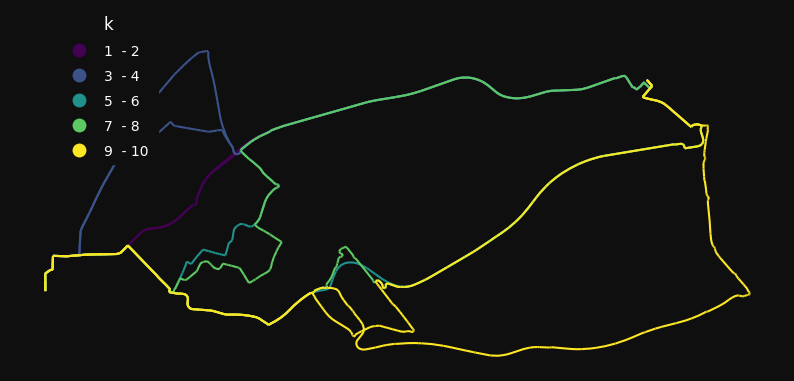

In [39]:
p1, p2 = bygg.loc[[2_470_929]], bygg.loc[[2_538_349]]

k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=1)

sg.qtm(k_routes, "k")

k_routes

Men kan stille strengere krav til hvor ulike rutene skal være. 

Med drop_middle_percent=50, fjernes midteste halvdel av ruta fra nettverket (midlertidig) før neste rute skal finnes.

/home/jovyan/arealrek/.venv/lib/python3.10/site-packages/sgis/maps/map.py:220: UserWarning: Could not create 5 classes.
  warnings.warn(f"Could not create {self._k} classes.")


origin  destination    minutes  k  \
0  2470929      2538349   8.977744  1   
1  2470929      2538349  12.295612  2   
2  2470929      2538349  15.386203  3   
3  2470929      2538349  17.419792  4   
4  2470929      2538349  19.936433  5   
5  2470929      2538349  25.519504  6   

                                            geometry  
0  MULTILINESTRING Z ((268028.442 6652506.931 153...  
1  MULTILINESTRING Z ((268242.300 6652393.600 135...  
2  MULTILINESTRING Z ((268242.300 6652393.600 135...  
3  MULTILINESTRING Z ((268028.442 6652506.931 153...  
4  MULTILINESTRING Z ((268028.442 6652506.931 153...  
5  MULTILINESTRING Z ((268242.300 6652393.600 135...

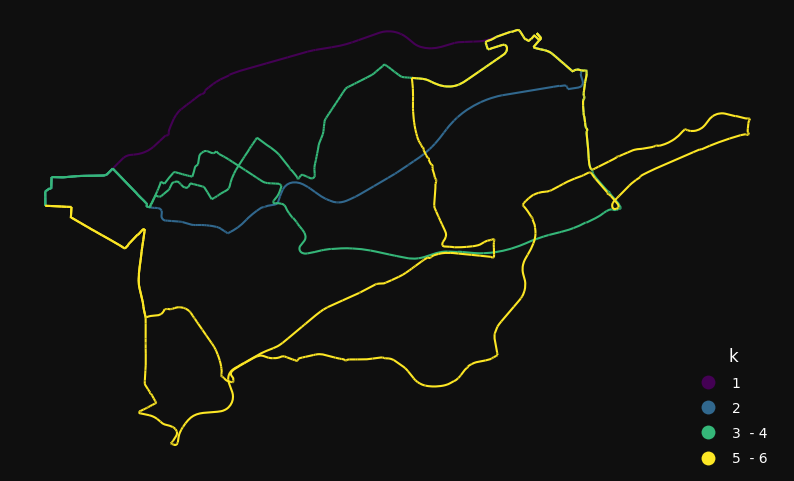

In [40]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=50)

sg.qtm(k_routes, "k")

k_routes

Her fant man bare seks ulike ruter. Med drop_middle_percent=100, finner man bare én rute:

origin  destination   minutes  k  \
0  2470929      2538349  8.977744  1   

                                            geometry  
0  MULTILINESTRING Z ((268028.442 6652506.931 153...

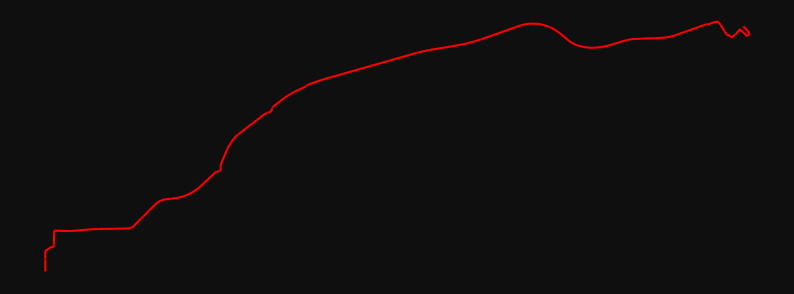

In [41]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=100)

sg.qtm(k_routes, "k", color="red")

k_routes